<font size="5">Статистический анализ данных испаноговорящих испытуемых (Statistical analysis of spanish speaking subjects inner speech) &#x1F60E; </font> 

<font size="2">На момент написания используются данные 10 испытуемых предварительно разделеннных на эпохи. Посчитаем спектры, выделим под-диапазон 60-65 в гамма диапазоне, посчитаем статистики между фон/слово и слово/cлово и посмотрим пересечения между испытуемыми.
(Ten subjects data divided to 1 sec epochs was used in this research. We will calculate PSD in 60-65 Hz band, t-test and anova comapring word pronaunce state and rest state) </font> 	&#x1F600;

In [1]:
import os 
import numpy as np
import mne
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from scipy.stats import ttest_ind, f_oneway
from scipy import signal

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler, SVMSMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE
from imblearn.ensemble import EasyEnsembleClassifier
import smote_variants
from xgboost import XGBRFClassifier

from mne.decoding import CSP

In [2]:
def getList(dict):
    list = []
    for key in dict.keys():
        list.append(key)
    return list

In [3]:
#подгрузка эпох. Лучше грузить без прелоуда, чтобы не грузить оперативку
#loading epoch without preload to avoid extra ram usage
mainPath = r'/home/dataFolder/DataPrior/Spanish/epo'
epoData = []
loadR = [1,10]
for i in range(loadR[0],loadR[1]):
    epoData.append(mne.read_epochs(mainPath + '/' + 'sub-{}'.format(i) + '/' + 'sub-{}-epo.fif'.format(i), preload = False, verbose = 0))

In [4]:
#посчитаем спектры в суббэнде гаммы
#calc PSD in gamma band's subband
psd = [epochmne.compute_psd(method='multitaper',fmin=60, fmax=65,n_jobs = -1)[[ 'BACK2',
                                                                                'DOWN2',
                                                                                'FORWARD2',
                                                                                'LEFT2',
                                                                                'NEXT2',
                                                                                'RIGHT2',
                                                                                'UP2','GO']] for epochmne in epoData]

Loading data for 1611 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 2188 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1081 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1148 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1637 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1532 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1600 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1405 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for

In [5]:
#усредним значения по диапазону, посчитем t статистику по всем каналам
#mean the spectrum and calc t test
resTest = {}
pThres = 0.01
for indx, sub in enumerate(psd):
    goSt = np.mean(sub['GO'].get_data(), axis = 2)
    stateDict = {}
    for state in getList(sub.event_id):
        curSt = np.mean(sub[state].get_data(), axis = 2)
        chRes = []
        # if aug == True:
        #     genX = np.append(goSt,curSt, axis = 0)
        #     genY = np.append()
        
        if state == 'GO':
            continue
        for ind, ch in enumerate(sub.ch_names):
            t, p = ttest_ind(curSt[:,ind], goSt[:,ind], equal_var=False)
            #t, p = f_oneway(curSt[:,ind], goSt[:,ind])
            
            stMean = np.mean(curSt[:,ind])
            goMean = np.mean(goSt[:,ind])
            
            if p < pThres:
                if stMean >  goMean:
                    chRes.append([ch,p])
                    
        stateDict[state] = chRes
    resTest[indx] = stateDict

In [6]:
#сгруппируем по словам, а не людям
#group by words
byWord = {}
for key in resTest[0].keys():
    cur = []
    for sesKey in resTest.keys():
        cur = cur + [i[0] for i in resTest[sesKey][key]]
    byWord[key] = cur

In [7]:
#посмомтрим насколько часто встречается канал
#let's see how common the channel is
frequency = {}
for keys in byWord.keys():
    test_list = byWord[keys]
    unique_elements = set(test_list)
    frequency[keys] = {item: test_list.count(item) for item in unique_elements}

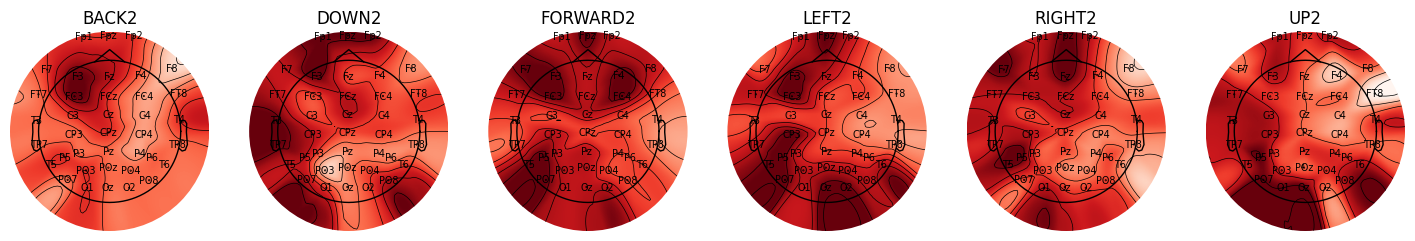

In [8]:
#построим на топокарте 
#let's plot a commonnes distribution on topomap
freqData = {item: [frequency[item][ch] if ch in getList(frequency[item]) else 0 for ch in epoData[0].ch_names] for item in frequency.keys()}
_, pos, _, _, _, _, _ = mne.viz.topomap._prepare_topomap_plot(epoData[0].info, 'eeg',sphere = 'auto')
fig, axes = plt.subplots(1, len(freqData.keys()), figsize = (18,10))
for idx, key in enumerate(freqData.keys()):
    axes[idx].set_title(key)
    mne.viz.plot_topomap(freqData[key], pos, names = epoData[0].ch_names, axes = axes[idx], show = False)
plt.show()
#fig.savefig('st<go.png')

In [9]:
#ранжируем список частот появления каналов, сохранив индексы (формат: (индекс, значение)). Индекс нужен, чтобы знать название канала
#sort the commoness list saving indices
sortFreq = {word: sorted(enumerate(freqData[word]), key=lambda i: i[1]) for word in freqData.keys()}
#теперь необходимо найти первый квартиль? или первые десять процентов наибольших значений?
#is it reasonable to look only for the most common channels? let's say the first quartile? or may be first 10%?
firstQ = {}
for word in sortFreq:
    m = 9 * (len(sortFreq[word]) + 1) // 10
    firstQ[word] = sortFreq[word][m:]
####найдем пересечения для значимых каналов####
#уникальные каналы
#find unique channels
uniCh = np.concatenate([[j[0] for j in firstQ[word]] for word in firstQ.keys()])
#пройдёмся по этим каналам и словам
#iterate through channels and words, reform data structure
chFreq = {}
for ch in uniCh:
    chFreq[epoData[0].ch_names[ch]] = []
    for word in firstQ.keys():
        for el in firstQ[word]:
            if ch == el[0]:
                chFreq[epoData[0].ch_names[ch]].append(word)

In [10]:
#представим полученные результаты в виде матрицы
#form the result as matrix hoping to group words by channels
matchMat = np.zeros((7, len(epoData[0].ch_names)))
for j_ind, ch in enumerate(epoData[0].ch_names):
    if ch in chFreq.keys():
        for i_ind, word in enumerate(firstQ.keys()):
            if word in chFreq[ch]:
                matchMat[i_ind,j_ind] = 1
            else:
                continue
    else:
        continue        

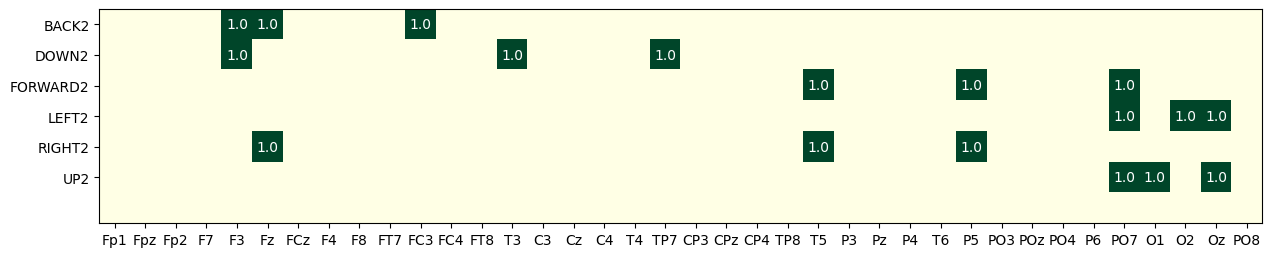

In [11]:
#построим
#plot the result
fig1, ax1 = plt.subplots(figsize = (15,5))
im = ax1.imshow(matchMat, cmap="YlGn")

ax1.set_xticks(np.arange(len(epoData[0].ch_names)), epoData[0].ch_names)
ax1.set_yticks(np.arange(len(firstQ.keys())), labels = firstQ.keys())

for i in range(len(epoData[0].ch_names)):
    for j in range(len(firstQ.keys())):
        if matchMat[j, i] != 0:
            text = ax1.text(i, j, matchMat[j, i],
                           ha="center", va="center", color="w")

<font size="2.5">**Impact of Class Imbalance on SVM with RBF Kernel**</font>

--Bias Towards Majority Class: In imbalanced datasets, SVM tends to classify most instances as belonging to the majority class. This is particularly problematic when the minority class is of   significant interest, as the classifier may ignore important patterns associated with the minority class, leading to poor recall and overall performance.

--Parameter Sensitivity: The performance of SVM with RBF kernel is sensitive to the parameters  C (the penalty for misclassification) and γ (which defines the influence of a single training example). When dealing with imbalanced data, careful tuning of these parameters is crucial. A high C value can lead to overfitting, especially when the minority class is underrepresented, while a low  C may result in underfitting.

In [79]:
#посмотрим, как после своеобразного "channel selection" будет работать бинарная классификация гамма диапаозона в ГО/слово в loso кросс-валидации
#let's see how our "channel selection" results works  on binary classifiaction task with LOSO estimation
saveTrain = True
overSampTest = False
saved_x = []
saved_y = []
saved_pred = []
accuracies = []
overSamp = True
for w_ind, word in enumerate(firstQ.keys()):
    acc_cur = []
    for indx, sub in enumerate(psd):
        #подготовим пайплайн со стандартизацией и смешиванием данных
        #prepare pipeline with standartization and shuffling with random forest as an output unit
        pipeline = Pipeline([
            #('scaler', StandardScaler()), 
            ('classifier', RandomForestClassifier(n_estimators = 700,random_state=42, n_jobs = -1))
            #('classifier', ExtraTreesClassifier(n_estimators = 700,random_state=42, class_weight = 'balanced', n_jobs = -1))
            #('xgb', XGBRFClassifier(n_estimators = 700, class_weight = 'balanced', n_jobs = -1))
            #('classifier', LinearDiscriminantAnalysis())
            #('pca', PCA(n_components = 3)),
            #('svm', SVC(kernel='rbf', gamma='scale'))
            #('svm', SVC(kernel='linear'))
            #('classifier', GaussianNB())
        ])
        #########################################################################################
        #значимые каналы под слово
        #significant channels for current word
        ch_ind = np.squeeze(np.argwhere(matchMat[w_ind,:] == 1))
        #тренировочный сет, данные всех испутемых кроме текущего
        #train set, concatenate data of all subjects except current one
        train_x = np.concatenate([np.mean(x[['GO', word]].get_data(), axis = 2)[:,ch_ind] for i,x in enumerate(psd) if i!=indx])
        train_y = np.concatenate([y[['GO', word]].events[:,2] for i,y in enumerate(psd) if i!=indx])
        #если надо уравнять классы
        #if oversampling is needed
        if overSamp == True:
            #over_sampler = SMOTE()
            #over_sampler = SVMSMOTE(k_neighbors = 15,m_neighbors = 3)
            over_sampler = smote_variants.Supervised_SMOTE()
            #over_sampler = ADASYN()
            #over_sampler = BorderlineSMOTE()
            #over_sampler = RandomOverSampler(random_state=42)
            train_x, train_y = over_sampler.sample(train_x, train_y)
        if saveTrain == True:
            saved_x.append(train_x)
            saved_y.append(train_y)
        #тестовый сет, данные текущего испытуемого
        #test set, data of current subject
        test_x = np.mean(sub[['GO', word]].get_data(), axis = 2)[:,ch_ind]
        test_y = sub[['GO', word]].events[:,2]
        if overSampTest == True:
            over_sampler = smote_variants.Supervised_SMOTE()
            test_x, test_y = over_sampler.sample(test_x, test_y)
        #перетасовка данных
        #data shuffle
        train_x, train_y = shuffle(train_x, train_y, random_state = 11)
        test_x, test_y = shuffle(test_x, test_y, random_state = 11)
        #обучение fitting
        pipeline.fit(train_x, train_y)
        #тест testing
        y_pred = pipeline.predict(test_x)
        saved_pred.append(y_pred)
        acc_cur.append(accuracy_score(test_y, y_pred))
    accuracies.append(acc_cur)

2024-08-15 10:44:39,150:INFO:Supervised_SMOTE: Running sampling via ('Supervised_SMOTE', "{'proportion': 1.0, 'th_lower': 0.5, 'th_upper': 1.0, 'classifier': ('sklearn.ensemble', 'RandomForestClassifier', {'n_estimators': 50, 'n_jobs': 1, 'random_state': 5}), 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'Supervised_SMOTE'}")
2024-08-15 10:44:39,210:INFO:Supervised_SMOTE: simplex sampling with n_dim 2
2024-08-15 10:44:39,267:INFO:Supervised_SMOTE: simplex sampling with n_dim 2
2024-08-15 10:44:39,305:INFO:Supervised_SMOTE: simplex sampling with n_dim 2
2024-08-15 10:44:39,342:INFO:Supervised_SMOTE: simplex sampling with n_dim 2
2024-08-15 10:44:41,503:INFO:Supervised_SMOTE: Running sampling via ('Supervised_SMOTE', "{'proportion': 1.0, 'th_lower': 0.5, 'th_upper': 1.0, 'classifier': ('sklearn.ensemble', 'RandomForestClassifier', {'n_estimators': 50, 'n_jobs': 1, 'r

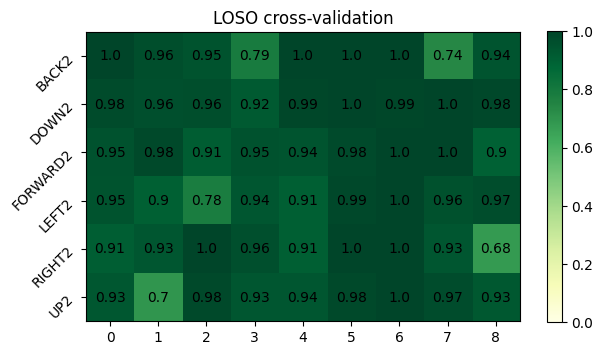

In [103]:
accuracies = np.array(accuracies)
#построим результаты точностей 
#build heatmap of resulting loso accuracies
fig2, ax2 = plt.subplots(figsize = (7,7))
im = ax2.imshow(accuracies, cmap="YlGn", vmin = 0.0, vmax = 1.0)
###########################################
ax2.set_yticks(np.arange(accuracies.shape[0]), labels = firstQ.keys(), rotation = 45)
ax2.set_title('LOSO cross-validation')
for i in range(accuracies.shape[0]):
    for j in range(accuracies.shape[1]):
            text = ax2.text(j, i, round(accuracies[i, j], 2),
                           ha="center", va="center", color="black")
fig2.colorbar(im, shrink=0.54)

<font size="2.7">*Что это всё значит? <br>
по оси ординат приведены испытуемые, по ориднате слова, в самой ячейке - значение точности и мы видим плохие результаты (едва ли выше случайного порога), но статистическим отбором каналов и нелинейным свм мы добились однордных результатов лосо кросс-валидации*</font>

In [100]:
#медианная кросс-валидационная точность
#median cross-validation accuracy
np.array([np.mean(accuracies, axis = 1)]).T
#всё плохо, если попробовать классификацию на всех каналах, или на тех, которые дали плохие стат результаты -конечный результат будет таким же (при использовании случайного леса)

array([[0.83910247],
       [0.95605425],
       [0.91673708],
       [0.92786773],
       [0.91072644],
       [0.94281171]])

In [69]:
# import pandas as pd
# for i in range(len(saved_x)):
#     data = pd.DataFrame(np.append(saved_x[i],np.array([saved_y[i]]).T, axis = 1), columns = ['{}'.format(j) if j != saved_x[i].shape[1] else 'label' for j in range(saved_x[i].shape[1] + 1)])
#     sns.pairplot(data, hue = 'label')
#     plt.savefig('/home/dataFolder/Ekizyan/Prior/images/pairplot/fig-{}.png'.format(i))
#     plt.close()

In [106]:
#loso результаты плохие, попробуем subject-dependent
overSamp = True
accuracies = []
for w_ind, word in enumerate(firstQ.keys()):
    acc_cur = []
    for indx, sub in enumerate(psd):
        clf = Pipeline([
            ('scaler', StandardScaler()), 
            ('svm', SVC(kernel='rbf', gamma='scale'))
        ])
        ch_ind = np.squeeze(np.argwhere(matchMat[w_ind,:] == 1))
        #тренировочный сет, данные всех испутемых кроме текущего
        #train set, concatenate data of all subjects except current one
        X = np.mean(sub[['GO', word]].get_data(), axis = 2)[:,ch_ind]
        y = sub[['GO', word]].events[:,2]
        if overSamp == True:
            over_sampler = smote_variants.Supervised_SMOTE()
            X, y = over_sampler.sample(X, y)
        data = pd.DataFrame(np.append(X,np.array([y]).T, axis = 1), columns = ['{}'.format(j) if j != X.shape[1] else 'label' for j in range(X.shape[1] + 1)]).sort_values('label').reset_index(drop=True)
        #add new feature - mean distance among points in feature space
        d__ = []
        for l in np.unique(data['label']):
            n = data.loc[data['label'] == l,:].values
            d_ = []
            for i in range(n.shape[0]):
                k = []
                for j in range(n.shape[0]):
                    k.append(np.sqrt((n[i,0] - n[j,0])**2 + (n[i,1] - n[j,1])**2 + (n[i,0] - n[j,0])**2))
                d_.append(np.mean(k))
            d__ = d__ + d_
        data.insert(loc=3, column='3', value=d__)
        train_x, test_x, train_y, test_y = train_test_split(data.iloc[:,:-1], data['label'], test_size=0.33, random_state=42)
        #обучение fitting
        clf.fit(train_x, train_y)
        #тест testing
        y_pred = clf.predict(test_x)
        acc_cur.append(accuracy_score(test_y, y_pred))
    accuracies.append(acc_cur)
        # sns.pairplot(data, hue = 'label')
        # plt.savefig('/home/dataFolder/Ekizyan/Prior/images/pairplot/fig-{}-{}.png'.format(word,indx))
        # plt.close()

In [112]:
#получаются хорошие результаты, особенно после добавления нового признака
print('Среднее по словам \n',np.array([np.mean(accuracies, axis = 1)]).T)
print('Среднее по людям \n',np.array([np.mean(accuracies, axis = 0)]).T)

Среднее по словам 
 [[0.92452947]
 [0.97393158]
 [0.94773949]
 [0.92077506]
 [0.92087692]
 [0.9378807 ]]
Среднее по людям 
 [[0.94470314]
 [0.91568228]
 [0.90204909]
 [0.93289193]
 [0.9494241 ]
 [0.98487854]
 [0.98920974]
 [0.93045491]
 [0.8893061 ]]


In [ ]:
#надо попробовать объеденить слова в один класс
overSamp = True
accuracies = []
for w_ind, word in enumerate(firstQ.keys()):
    acc_cur = []
    for indx, sub in enumerate(psd):